## Image Preparation

Generating patches from mosaics.  
  
imagePatcherSemSeg.py is refered to make preparation program below.  

imagePatcherSemSeg.py is used for deviding a mosaic image and GT segmentation images into the patches like this.  
``` 
$ python imagePatcherSemSeg.py ./datasets/wM1 500 ./results/ wM
```
Here, 500 is the length of a side of a patch.  
  
To gain the number of patches, 
- Rotated patches (90, 180 and 270 degree) are also generated for each patches
- Scale shifted patches (1280, 1280) is generated and resized into same size (640, 640)
- gaussian noise
- high contrast

Data argumentation  
https://qiita.com/bohemian916/items/9630661cd5292240f8c7

In [1]:
import cv2, numpy as np

Parameters

In [23]:
VERBOSE = True
LAYER_FOCUS =  [False,       False,       True,        True,        False,      True]
LAYER_NAMES =  ["river",     "uncovered", "evergreen", "decidious", "manmade",  "nothing"] # "nothing" must be the last
LAYER_COLORS = [(64,128,64), (0,128,192), (128,0,0),   (192,0,128), (64,0,128), (255,255,255)] # later is prioritized (except "nothing")
LAYER_COLORS_FOCUS = np.array(LAYER_COLORS)[LAYER_FOCUS].tolist()
LAYER_LEN = len(LAYER_NAMES)
LAYER_LEN_FOCUS = len(LAYER_COLORS_FOCUS)

# MOSAIC_NAMES = ["wM1", "wM2", "wM3", "wM4", "wM5", "wM6", "wM7"]
MOSAIC_NAMES = ["wM1", "wM2"]
# PATCH_SIZES = [640, 1280, 2560]
PATCH_SIZES = [640]
ROTATE = False

GAUSSIAN = False
GAUSSIAN_PROB = 0.5
GAUSSIAN_SIGMA = 30

CONTRAST = False
CONTRAST_PROB = 0.5
CONTRAST_MAX = 180
CONTRAST_MIN = 70
CONTRAST_LUT = np.arange(256, dtype = 'uint8')
for i in range(0, CONTRAST_MIN):
    CONTRAST_LUT[i] = 0
for i in range(CONTRAST_MIN, CONTRAST_MAX):
    CONTRAST_LUT[i] = 255 * (i - CONTRAST_MIN) / (CONTRAST_MAX - CONTRAST_MIN)
for i in range(CONTRAST_MAX, 255):
    CONTRAST_LUT[i] = 255

SMOOTHING = True
SMOOTHING_PROB = 0.5
SMOOTHING_KERNEL = (25, 25)

RESIZE_TO = 640 # needs to be multiple of 640 for the u-net. why? somehow it outputs 496*496 predictions
EMPTY_THRESHOLD = 50 # for RESIZE_TO size
INDEX_DIGITS = 5

DATASET_DIR = "../datasets/forests/"
OUTPUT_DIR = DATASET_DIR + "patches/focused/"
SEGM_DIR = OUTPUT_DIR + "segmentation/"
MOSAIC_DIR = OUTPUT_DIR + "mosaic/"
SEGM_VEC_DIR = OUTPUT_DIR + "segmentation_vector/"

Reading layer images

In [21]:
layers = [[] for i in range(len(MOSAIC_NAMES))]

for mosaic_id, mosaic_name in enumerate(MOSAIC_NAMES):
    for layer_id, layer_name in enumerate(LAYER_NAMES[:-1]):
        layer_file_name = f"{DATASET_DIR}{mosaic_name}_{layer_name}.jpg"
        layer = cv2.imread(layer_file_name, cv2.IMREAD_GRAYSCALE)
        layers[mosaic_id].append(layer)
        if layer is not None:
            if VERBOSE: print(f"Get layer image: {layer_file_name}")

layers_focus = np.array(layers)[0]

Get layer image: ../datasets/forests/wM1_river.jpg
Get layer image: ../datasets/forests/wM1_uncovered.jpg
Get layer image: ../datasets/forests/wM1_evergreen.jpg
Get layer image: ../datasets/forests/wM1_decidious.jpg
Get layer image: ../datasets/forests/wM1_manmade.jpg
Get layer image: ../datasets/forests/wM2_river.jpg
Get layer image: ../datasets/forests/wM2_uncovered.jpg
Get layer image: ../datasets/forests/wM2_evergreen.jpg
Get layer image: ../datasets/forests/wM2_decidious.jpg


Generating patches  
Empty patches are skipped

In [27]:
def crop_square(image, left, top, size):
    return image[ left : left + size, top : top + size]

def contrast(image):
    return cv2.LUT(image, CONTRAST_LUT)

def gaussian(image):
    gauss = np.random.normal(0, GAUSSIAN_SIGMA, image.shape)
    return np.clip(image + gauss, 0, 255)

def resize(image):
    return cv2.resize(image, (RESIZE_TO, RESIZE_TO))


identity = np.identity(LAYER_LEN_FOCUS)

patch_count = 0

for m, name in enumerate(MOSAIC_NAMES):

    mosaic = cv2.imread(f"{DATASET_DIR}{name}.jpg")
    size_x, size_y, _ = mosaic.shape
    
    # Delete unforcused layers in the mosaic
    for i, focus in enumerate(LAYER_FOCUS):
        if not focus and layers[m][i] is not None:
            mosaic[layers[m][i] <= 30] = 255
    
    layers_focus[m] = np.array(layers[m])[LAYER_FOCUS[:-1]]
    
    if VERBOSE: print(f"Create patches for {DATASET_DIR}{name}.jpg")
    
    for patch_size in PATCH_SIZES:

        layer_patch_is_empty = lambda layer_patch: \
            np.sum(layer_patch == 0) <= int(EMPTY_THRESHOLD * (patch_size / RESIZE_TO))

        crop_patch = lambda image, i, j: \
            crop_square(image, i * patch_size, j * patch_size, patch_size)

        step_x, step_y = np.array([size_x, size_y]) // patch_size

        for i in range(step_x):
            for j in range(step_y):

                segm_patch = np.full((patch_size, patch_size, 3), 255, dtype=np.uint8)
                segm_patch_vec = np.zeros((patch_size, patch_size, LAYER_LEN_FOCUS), dtype=np.float32)
                segm_patch_vec[:, :, -1] = 1
                
                # paint the empty patch by layer
                segm_patch_is_empty = True
                for layer_id, layer in enumerate(layers_focus[m]):
                    layer_patch = crop_patch(layer, i, j)

                    if( layer_patch_is_empty(layer_patch) ): continue
                    segm_patch_is_empty = False
                    
                    segm_patch[layer_patch == 0] = LAYER_COLORS_FOCUS[layer_id] # for nothing
                    segm_patch_vec[layer_patch == 0] = identity[layer_id]

                # start saving the patches if any layer is not empty
                if(segm_patch_is_empty): continue

                # resize patches (for scale change)
                segm_patch = resize(segm_patch)
                segm_patch_vec = resize(segm_patch_vec)
                mosaic_patch = resize(crop_patch(mosaic, i, j))

                # rotate patches and save them
                for r in range(4 if ROTATE else 1):
                    index = str(patch_count).zfill(INDEX_DIGITS)
                    
                    segm_patch_name = f"{SEGM_DIR}{index}_{name}_{i}-{j}_{patch_size}_r{r*90}_Segmentation.jpg"
                    cv2.imwrite(segm_patch_name, np.rot90(segm_patch, k=r))
                    
                    segm_patch_vec_name = f"{SEGM_VEC_DIR}{index}_{name}_{i}-{j}_{patch_size}_r{r*90}_SegmentationVector"
                    np.save(segm_patch_vec_name, np.rot90(segm_patch_vec, k=r))

                    mosaic_patch_name = f"{MOSAIC_DIR}{index}_{name}_{i}-{j}_{patch_size}_r{r*90}_Mosaic.jpg"
                    cv2.imwrite(mosaic_patch_name, np.rot90(mosaic_patch, k=r))

                    patch_count += 1
                
                # Add Gaussian noise probabilistically
                if GAUSSIAN and np.random.binomial(1, GAUSSIAN_PROB):
                    index = str(patch_count).zfill(INDEX_DIGITS)
                    
                    segm_patch_name = f"{SEGM_DIR}{index}_{name}_{i}-{j}_{patch_size}_gaussian_Segmentation.jpg"
                    cv2.imwrite(segm_patch_name, segm_patch)
                    
                    segm_patch_vec_name = f"{SEGM_VEC_DIR}{index}_{name}_{i}-{j}_{patch_size}_gaussian_SegmentationVector"
                    np.save(segm_patch_vec_name, segm_patch_vec)

                    mosaic_patch_name = f"{MOSAIC_DIR}{index}_{name}_{i}-{j}_{patch_size}_gaussian_Mosaic.jpg"
                    cv2.imwrite(mosaic_patch_name, gaussian(mosaic_patch))

                    patch_count += 1
                
                # Emphasize contrast probabilistically
                if CONTRAST and np.random.binomial(1, CONTRAST_PROB):
                    index = str(patch_count).zfill(INDEX_DIGITS)
                    
                    segm_patch_name = f"{SEGM_DIR}{index}_{name}_{i}-{j}_{patch_size}_contrast_Segmentation.jpg"
                    cv2.imwrite(segm_patch_name, segm_patch)
                    
                    segm_patch_vec_name = f"{SEGM_VEC_DIR}{index}_{name}_{i}-{j}_{patch_size}_contrast_SegmentationVector"
                    np.save(segm_patch_vec_name, segm_patch_vec)

                    mosaic_patch_name = f"{MOSAIC_DIR}{index}_{name}_{i}-{j}_{patch_size}_contrast_Mosaic.jpg"
                    cv2.imwrite(mosaic_patch_name, contrast(mosaic_patch))

                    patch_count += 1
                
                # Gaussian smoothing effect
                if SMOOTHING and np.random.binomial(1, SMOOTHING_PROB):
                    index = str(patch_count).zfill(INDEX_DIGITS)
                    
                    segm_patch_name = f"{SEGM_DIR}{index}_{name}_{i}-{j}_{patch_size}_smoothing_Segmentation.jpg"
                    cv2.imwrite(segm_patch_name, segm_patch)
                    
                    segm_patch_vec_name = f"{SEGM_VEC_DIR}{index}_{name}_{i}-{j}_{patch_size}_smoothing_SegmentationVector"
                    np.save(segm_patch_vec_name, segm_patch_vec)

                    mosaic_patch_name = f"{MOSAIC_DIR}{index}_{name}_{i}-{j}_{patch_size}_smoothing_Mosaic.jpg"
                    cv2.imwrite(mosaic_patch_name, cv2.GaussianBlur(mosaic_patch, SMOOTHING_KERNEL, 0))

                    patch_count += 1
                

    if VERBOSE: print(f"{patch_count} patches are created so far")

Create patches for ../datasets/forests/wM1.jpg
301 patches are created so far
Create patches for ../datasets/forests/wM2.jpg
523 patches are created so far


## Semantic Segmentation by U-net

In [3]:
import os, random, time, cv2, numpy as np
from IPython.display import clear_output

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
from torch.autograd import Function, Variable
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline

Parameters

In [4]:
RESULT_DIR = './results/focused/'
CHECKPOINT_DIR =  RESULT_DIR + 'checkpoints/'
HISTORY_DIR = RESULT_DIR + 'histories/'

TEST_DATA_RATE = 0.03

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCH = 3
KFOLD_NUM = 5
BATCH_SIZE = 3
REPORT_INTERVAL = 100 # num of batch

Prepare patch names

In [5]:
mosaic_paths = [MOSAIC_DIR + file_name for file_name in sorted(os.listdir(MOSAIC_DIR))]
segm_paths = [SEGM_DIR + file_name for file_name in sorted(os.listdir(SEGM_DIR))]
segm_vec_paths = [SEGM_VEC_DIR + file_name for file_name in sorted(os.listdir(SEGM_VEC_DIR))]
all_pair_paths = np.array(list(zip(mosaic_paths, segm_paths, segm_vec_paths)))
all_pair_len = len(all_pair_paths)

random.shuffle(all_pair_paths)

test_len = int(all_pair_len * TEST_DATA_RATE)
test_paths, non_test_paths = all_pair_paths[:test_len], all_pair_paths[test_len:]

val_len = (all_pair_len - test_len) // KFOLD_NUM
train_len = all_pair_len - test_len - val_len

print("All patch pairs:", all_pair_len)
print("for tests:", test_len)
print("for training:",  train_len)
print("for training validation:", val_len)

All patch pairs: 8420
for tests: 252
for training: 6535
for training validation: 1633


Reading the image pair through the generator

In [6]:
def imread(paths):
    for path in paths:
        img = cv2.imread(path)
        img = np.array(img, dtype=np.float32)
        yield img

def load_vecs(paths):
    for path in paths:
        vec = np.load(path)
        yield vec

def patch_pairs(pair_paths):
    mosaic_img = imread([pair_path[0] for pair_path in pair_paths])
    mosaic_img = map(lambda x: np.transpose(x, axes=[2, 0, 1]), mosaic_img) # (3, Vertical, Horizontal)
    mosaic_img = map(lambda x: x / 255, mosaic_img) # normalize to [0, 1]
    
    segm_vec = load_vecs([pair_path[2] for pair_path in pair_paths])
    segm_vec = map(lambda x: np.transpose(x, axes=[2, 0, 1]), segm_vec)

    return zip(mosaic_img, segm_vec)

U-Net implementation using pytorch

In [7]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)
    
    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2), 
            double_conv(in_ch, out_ch)
        )
    
    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        
        self.conv = double_conv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2), diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)    
        x = self.conv(x)
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(3, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

Learning utils

In [8]:
class Outputter():
    def __init__(self, do=True):
        self.outputs = []
        self.do = do
    
    def save(self, filename):
        with open(filename, mode="w") as f:
            f.write("\n".join(self.outputs))
    
    def add(self, string):
        self.outputs.append(string)
        self.flush()
    
    def update(self, string):
        self.outputs[-1] = string
        self.flush()
    
    def conditional(self, string, condition):
        if condition:
            self.add(string)
        else:
            self.update(string)
    
    def flush(self):
        if not self.do: return
        clear_output()
        print("\n".join(self.outputs))

def init_weights(model):
    if type(model) == nn.Linear:
        nn.init.kaiming_normal_(model.weight)
        model.bias.data.fill_(0.01)

def make_batch(iterable, batch_size):
    b = []
    for i, t in enumerate(iterable):
        b.append(t)
        if (i + 1) % batch_size == 0:
            yield b
            b = []
    
    if len(b) > 0:
        yield b

def to_torch(np_array):
    if torch.cuda.is_available():
        return torch.from_numpy(np_array).cuda()
    return torch.from_numpy(np_array).cpu()

def prob_to_one_hot(prob):
    """input (C, H, W) probability output (H, W, C)"""
    one_hot_prob = to_torch(np.identity(LAYER_LEN_FOCUS, dtype=np.float32))
    argmax = prob.permute(1, 2, 0).argmax(dim=2)
    return one_hot_prob[argmax].permute(2, 0, 1)

def prob_to_segm(prob):
    """input (C, H, W) probability, output (H, W, C)"""
    layer_colors = to_torch(np.array(LAYER_COLORS_FOCUS))
    argmax = prob.permute(1, 2, 0).argmax(dim=2)
    return layer_colors[argmax].cpu().numpy()

Simple implementation of dice coeff

In [9]:
def dice_coeff(a, b):
    if a.shape != b.shape:
        raise ValueError("inputs must be same shape")
    a_flat, b_flat = a.flatten(), b.flatten()
    inter = torch.dot(a_flat, b_flat)
    union = torch.sum(a_flat) + torch.sum(b_flat)
    coeff = (2 * inter) / union
    return coeff.item()

Training U-net

In [10]:
EPOCH = 2
non_test_paths = non_test_paths[:100]
train_len = 80
val_len = 20
REPORT_INTERVAL = 10
BATCH_SIZE = 1

Start epoch: 1, k = 1
Training finished ! avg loss: 0.61971 | fold time: 13 [sec]
Validation finished ! avg loss: 0.58731 | avg dice coeff: 0.60359 | fold time: 1 [sec]
Start epoch: 1, k = 2
Training finished ! avg loss: 0.5907 | fold time: 13 [sec]
Validation finished ! avg loss: 0.56481 | avg dice coeff: 0.6199 | fold time: 1 [sec]
Start epoch: 1, k = 3
Training finished ! avg loss: 0.56915 | fold time: 14 [sec]
Validation finished ! avg loss: 0.54596 | avg dice coeff: 0.64538 | fold time: 1 [sec]
Start epoch: 1, k = 4
Training finished ! avg loss: 0.55143 | fold time: 14 [sec]
Validation finished ! avg loss: 0.52995 | avg dice coeff: 0.64737 | fold time: 1 [sec]
Start epoch: 1, k = 5
Training finished ! avg loss: 0.53573 | fold time: 14 [sec]
Validation finished ! avg loss: 0.5165 | avg dice coeff: 0.65593 | fold time: 1 [sec]
Checkpoint 1 saved !

Start epoch: 2, k = 1
Training finished ! avg loss: 0.44948 | fold time: 14 [sec]
Validation finished ! avg loss: 0.44551 | avg dice coe

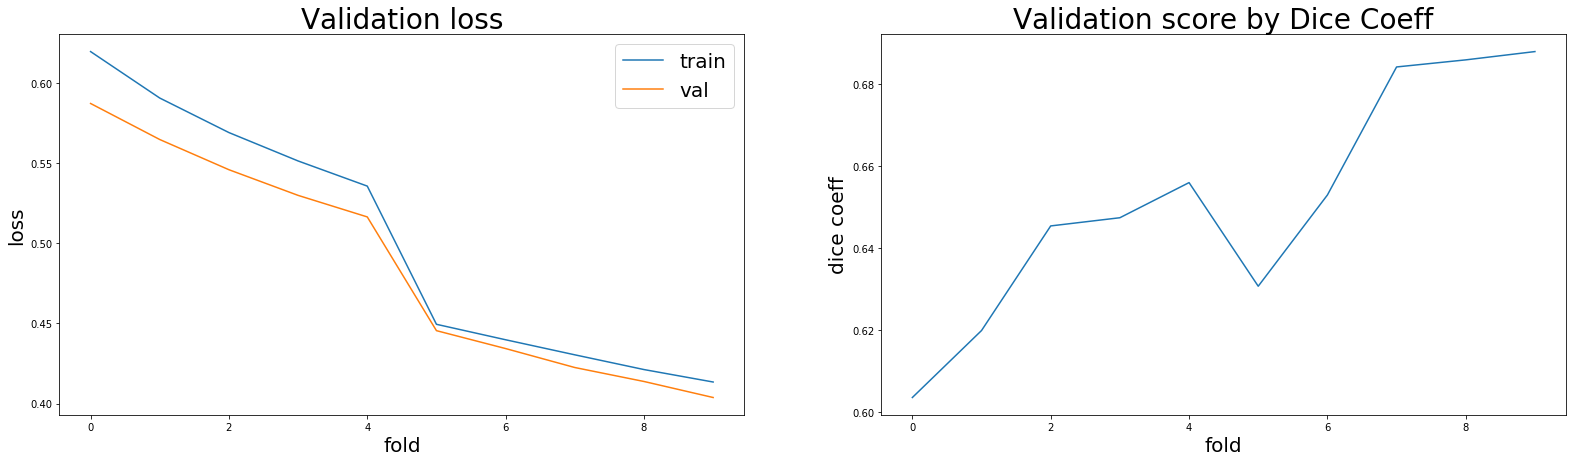

In [11]:
out = Outputter(VERBOSE)

net = UNet(LAYER_LEN_FOCUS)
net = net.cuda() if torch.cuda.is_available() else net.cpu()

net.apply(init_weights)
optimizer = optim.Adam(
    net.parameters(), 
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

criterion = nn.BCELoss()

train_losses = []
val_losses = []
dices = []

init_time = time.time()

for epoch in range(1, EPOCH+1):
    
    train_loss = 0
    val_loss = 0
    dice = 0

    # train section
    for k, (train_ids, val_ids) in enumerate(KFold(n_splits=KFOLD_NUM, shuffle=True).split(non_test_paths), start=1):
        out.add(f"Start epoch: {epoch}, k = {k}")
        
        train = patch_pairs(non_test_paths[train_ids])
        val = patch_pairs(non_test_paths[val_ids])
        
        start_time = time.time()
        for i, batch in enumerate(make_batch(train, BATCH_SIZE)):

            # load patch data
            mosaic = to_torch(np.array([b[0] for b in batch], dtype=np.float32))
            segm_vec = to_torch(np.array([b[1] for b in batch], dtype=np.float32))

            # predict and get the loss
            pred = net(mosaic) # (3, 6, 640, 640)
            prob = torch.sigmoid(pred)

            loss = criterion(prob.flatten(), segm_vec.flatten())
            train_loss += loss.item() * BATCH_SIZE

            # optimize the network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % REPORT_INTERVAL == 0:
                elapsed = time.time() - start_time
                progress = i / (train_len / BATCH_SIZE)
                left_time = "-" if i == 0 else int((elapsed / (progress)) * (1. - progress))
                itr_loss = "-" if i == 0 else train_loss / (i * BATCH_SIZE + (k - 1) * train_len)
                out.conditional("{} / {} trained | iteration loss: {:.5} | fold time: {} [sec] ({} [sec] left)" \
                                 .format(i * BATCH_SIZE, train_len, itr_loss, int(elapsed), left_time), i == 0)
        
        # Record and display the training result in a fold
        train_losses.append(train_loss / (k * train_len))
        out.update("Training finished ! avg loss: {:.5} | fold time: {} [sec]" \
                   .format(train_losses[-1], int(time.time() - start_time)))

        # validation section
        start_time = time.time()
        for i, batch in enumerate(make_batch(val, BATCH_SIZE)):

            # load validation batch data
            mosaic = to_torch(np.array([b[0] for b in batch], dtype=np.float32)) # (3, 6, 640, 640)
            segm_vec = to_torch(np.array([b[1] for b in batch], dtype=np.float32)) # (3, 6, 640, 640)

            # gradient calculation is unnecessary for validation
            with torch.no_grad():
                pred = net(mosaic) # (3, 6, 640, 640)
                prob = torch.sigmoid(pred) # (3, 6, 640, 640)

            # calculate dice coefficient:
            one_hots = [prob_to_one_hot(p) for p in prob]
            one_hots = zip(one_hots, segm_vec)
            dice += np.sum([dice_coeff(p, s) for p, s in one_hots])

            # calculate validation loss:
            loss = criterion(prob.flatten(), segm_vec.flatten())
            val_loss += loss.item() * BATCH_SIZE

            # report progress
            if i % REPORT_INTERVAL == 0:
                elapsed = time.time() - start_time
                progress = i / (val_len / BATCH_SIZE)
                itr_loss = "-" if i == 0 else val_loss / (i * BATCH_SIZE + (k - 1) * val_len)
                out.conditional("{} / {} vaidated | iteration loss: {:.5} | fold time: {} [sec] ({} [sec] left)" \
                                .format(i * BATCH_SIZE, val_len, itr_loss, int(elapsed), left_time), i == 0)
        
        # Record and display the validation result in a fold
        val_losses.append(val_loss / (k * val_len))
        dices.append(dice / (k * val_len))
        out.update("Validation finished ! avg loss: {:.5} | avg dice coeff: {:.5} | fold time: {} [sec]" \
                   .format(val_losses[-1], dices[-1], int(time.time() - start_time)))
    
    # create checkpoint of this epoch
    torch.save(net.state_dict(), f"{CHECKPOINT_DIR}cp_{epoch}.pth")
    out.add(f"Checkpoint {epoch} saved !\n")

finish_time = int(time.time() - init_time)
epoch_time = finish_time // EPOCH
fold_time = epoch_time // KFOLD_NUM
out.add("All training finished in {} [sec] ! {} [sec/epoch], {} [sec/fold]"\
        .format(finish_time, epoch_time, fold_time))

out.save(f"{RESULT_DIR}output.txt")
np.save(f"{HISTORY_DIR}train_loss", train_losses)
np.save(f"{HISTORY_DIR}val_loss", val_losses)
np.save(f"{HISTORY_DIR}dice", dices)

# Show the training result by matplotlib graphs
fig = plt.figure(figsize=(27, 7))

ax1 = fig.add_subplot(121)
ax1.plot(train_losses, label="train")
ax1.plot(val_losses, label="val")
ax1.set_title('Validation loss', fontsize=28)
ax1.set_xlabel('fold', fontsize=20)
ax1.set_ylabel('loss', fontsize=20)
ax1.legend(fontsize=20)

ax2 = fig.add_subplot(122)
ax2.plot(dices)
ax2.set_title('Validation score by Dice Coeff', fontsize=28)
ax2.set_xlabel('fold', fontsize=20)
ax2.set_ylabel('dice coeff', fontsize=20)

plt.show()

Validation by the test data

Test for: ../datasets/forests/patches/mosaic/00018_wM1_0-13_640_gaussian_Mosaic.jpg
Test Dice Coefficient: 0.52077


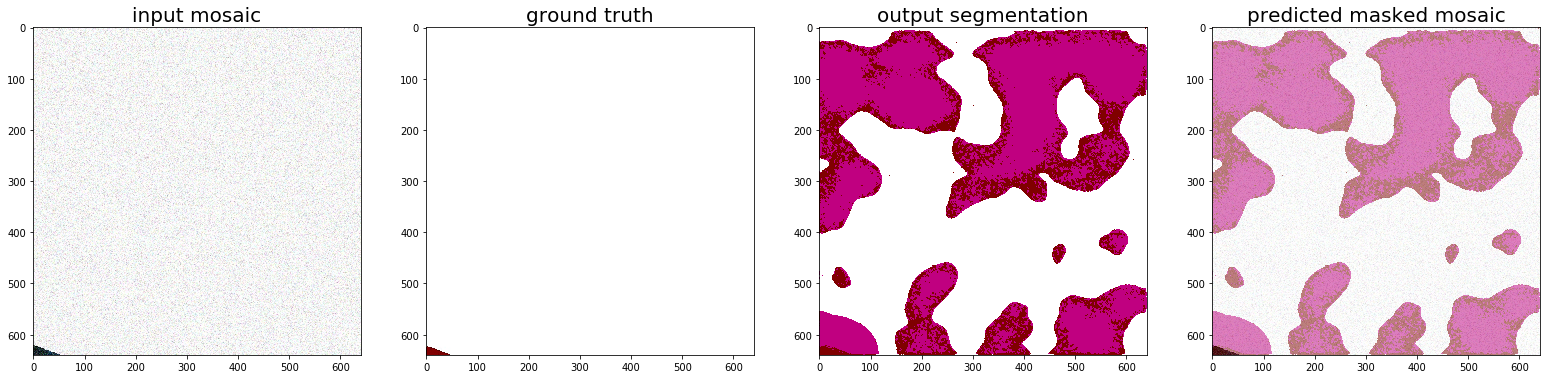

Test for: ../datasets/forests/patches/mosaic/00048_wM1_1-11_640_270_Mosaic.jpg
Test Dice Coefficient: 0.96395


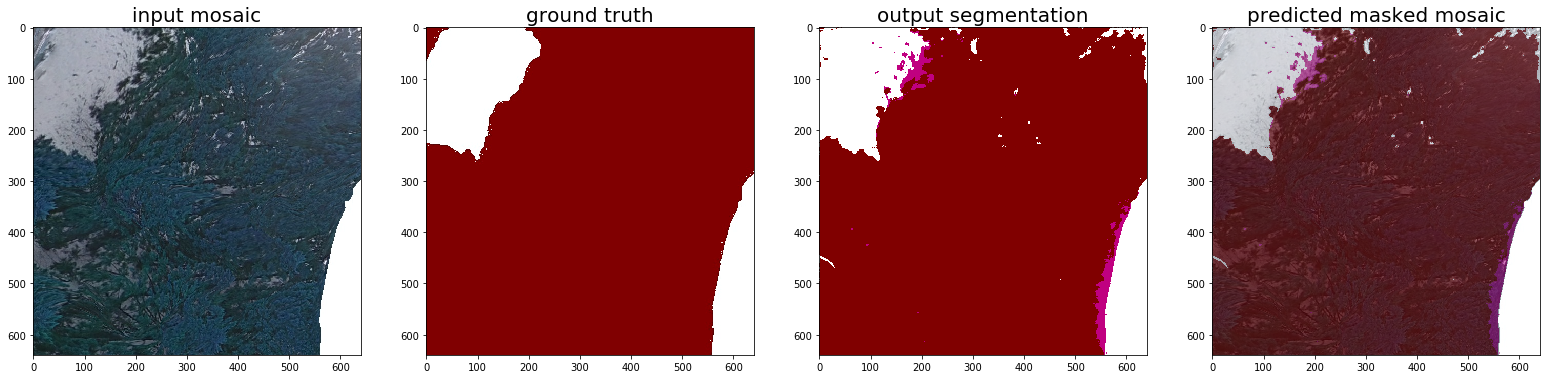

Test for: ../datasets/forests/patches/mosaic/00077_wM1_2-5_640_0_Mosaic.jpg
Test Dice Coefficient: 0.55781


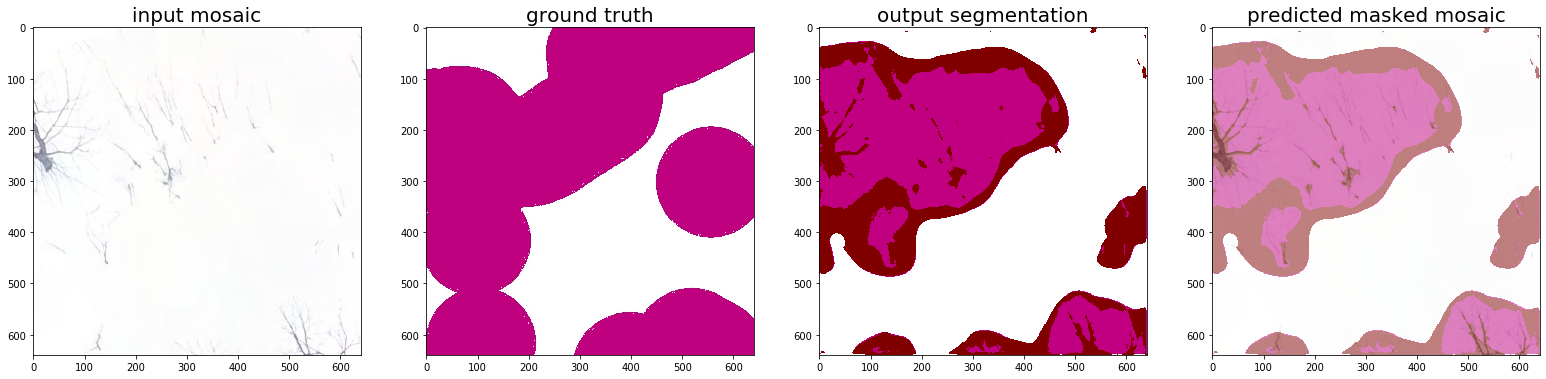

Test for: ../datasets/forests/patches/mosaic/00088_wM1_2-7_640_90_Mosaic.jpg
Test Dice Coefficient: 0.67055


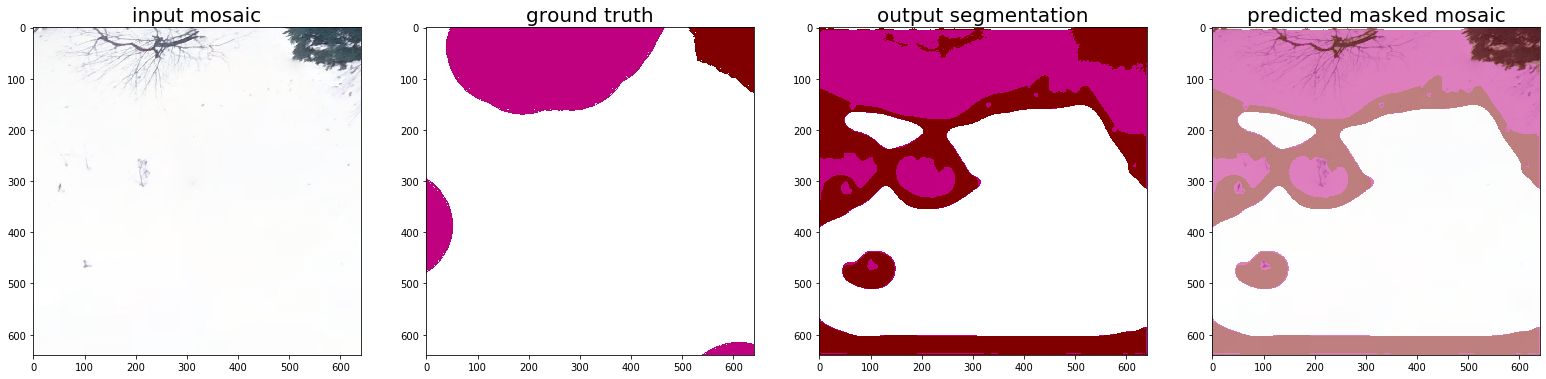

Test for: ../datasets/forests/patches/mosaic/00073_wM1_2-4_640_180_Mosaic.jpg
Test Dice Coefficient: 0.57794


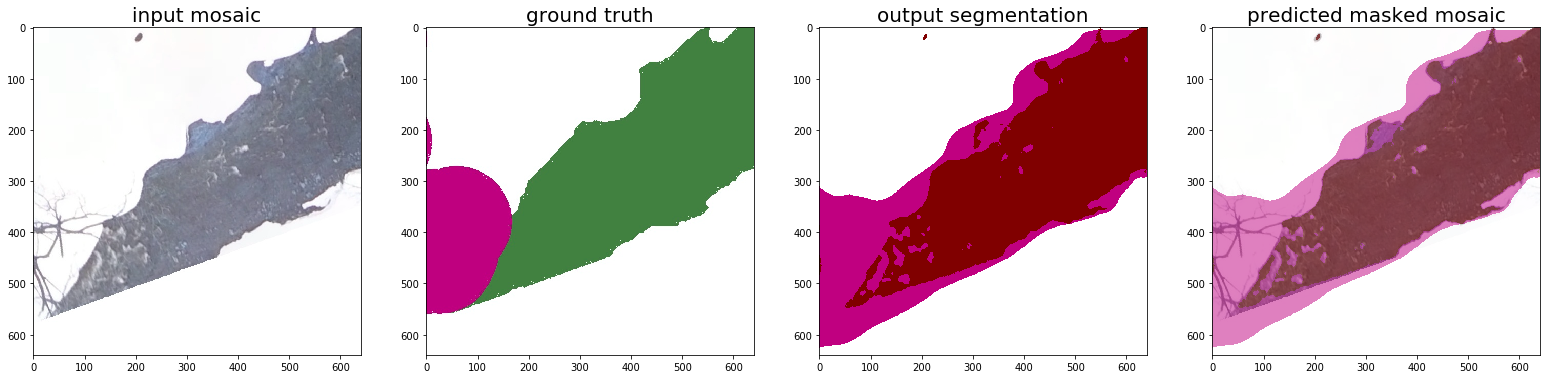

Test for: ../datasets/forests/patches/mosaic/00020_wM1_1-5_640_90_Mosaic.jpg
Test Dice Coefficient: 0.68318


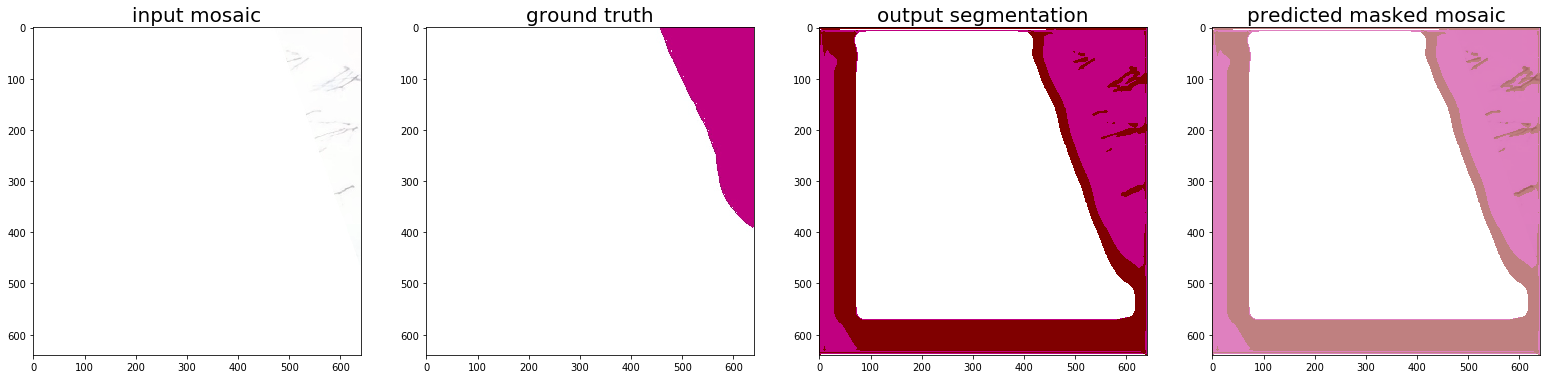

Test for: ../datasets/forests/patches/mosaic/00022_wM1_1-5_640_270_Mosaic.jpg
Test Dice Coefficient: 0.71347


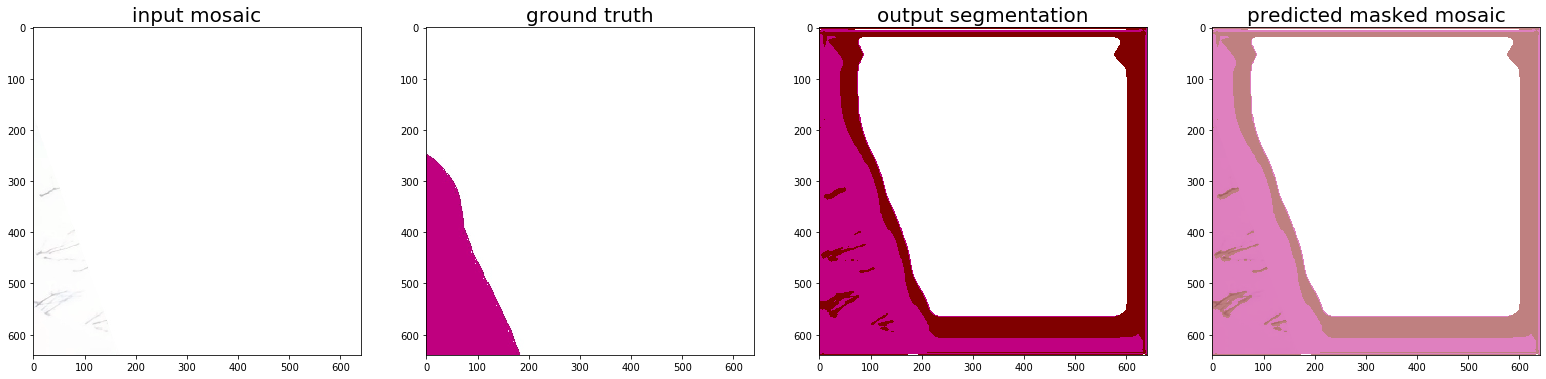

Test for: ../datasets/forests/patches/mosaic/00011_wM1_0-12_640_90_Mosaic.jpg
Test Dice Coefficient: 0.60491


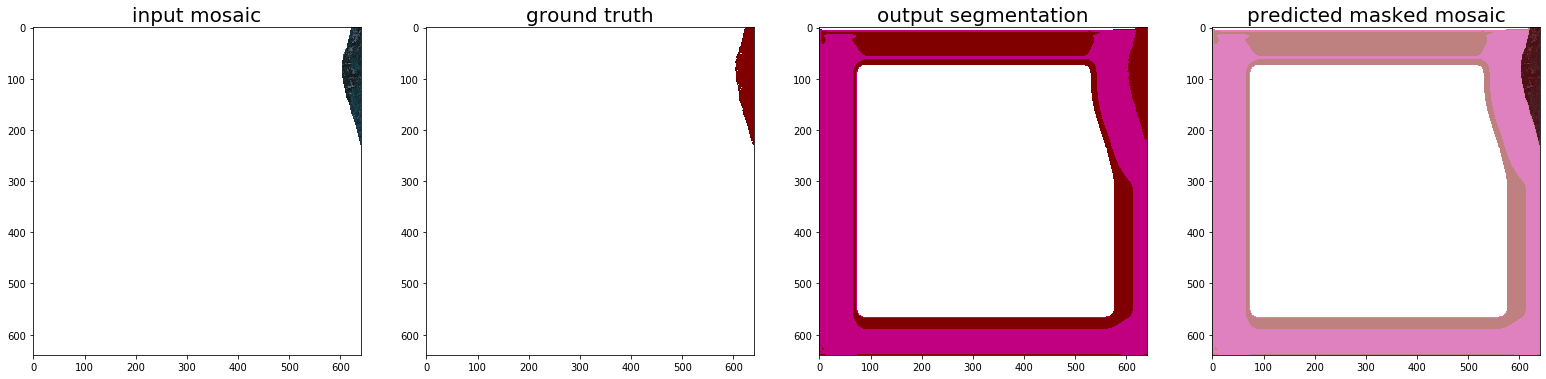

Test for: ../datasets/forests/patches/mosaic/00182_wM1_3-11_640_gaussian_Mosaic.jpg
Test Dice Coefficient: 0.87068


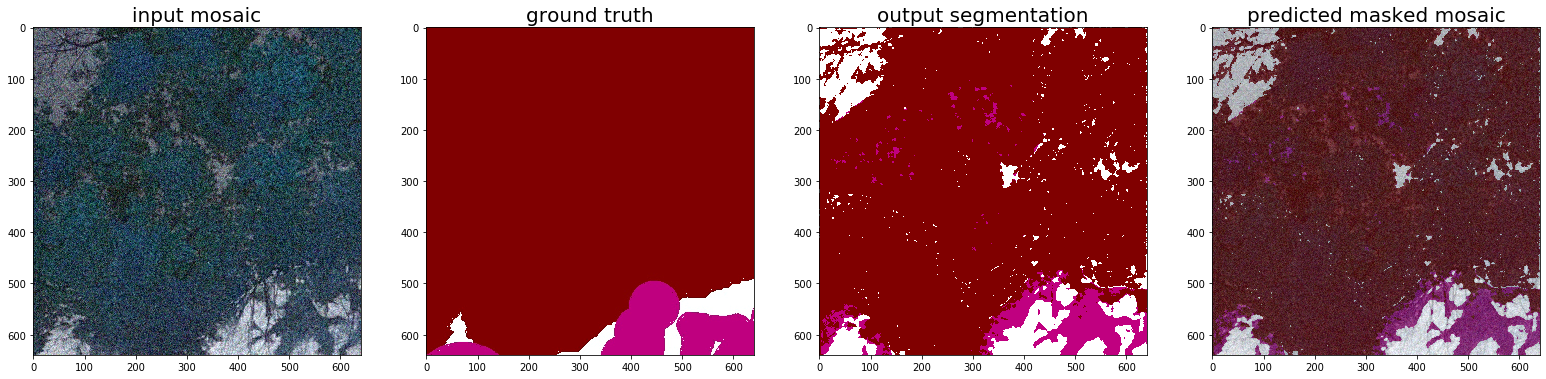

Test for: ../datasets/forests/patches/mosaic/00025_wM1_1-6_640_180_Mosaic.jpg
Test Dice Coefficient: 0.60815


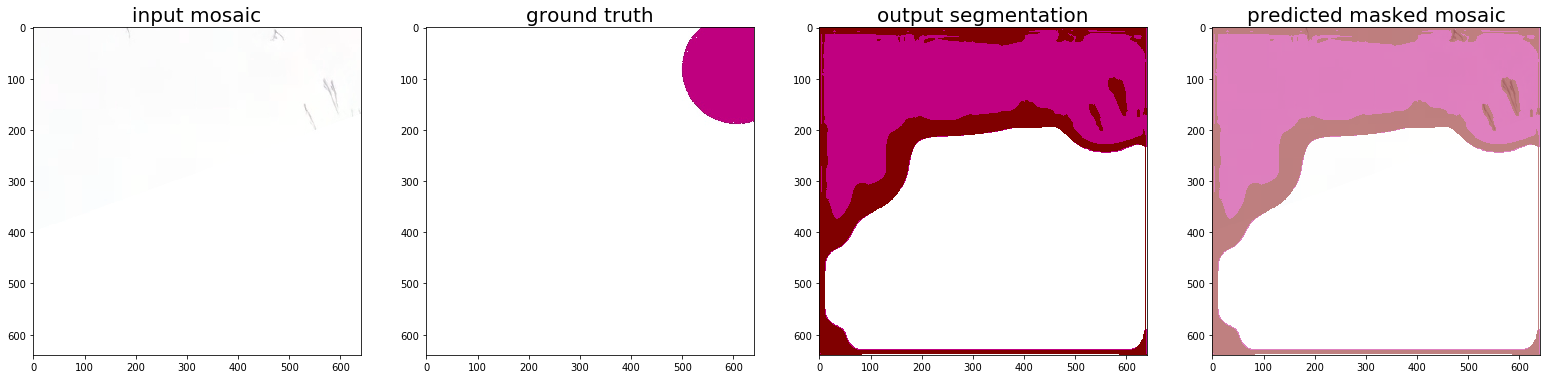

In [12]:
# gradient calculation is unnecessary because this is not training
LIMIT = 10

np.random.shuffle(test_paths)

with torch.no_grad():
    for i, test_path in enumerate(test_paths):

        if i >= LIMIT: break
        
        # Reading test image
        print("Test for:", test_path[0])
        test_mosaic = cv2.imread(test_path[0])
        test_segm = cv2.imread(test_path[1])
        test_segm_vec = to_torch(np.load(test_path[2])) # (640, 640, 3)
        
        # Prediction
        mosaic = np.array(test_mosaic, dtype=np.float32) / 255
        pred = net(to_torch(np.transpose(mosaic, axes=[2, 0, 1])).unsqueeze(0))
        prob = torch.sigmoid(pred).squeeze(0)
        pred_segm = prob_to_segm(prob) # (6, 640, 640) -> (640, 640, 3)
        
        # Take dice coefficient
        one_hot_prob = prob_to_one_hot(prob).permute(1, 2, 0) # (6, 640, 640) -> (640, 640, 3)
        print("Test Dice Coefficient:", round(dice_coeff(one_hot_prob, test_segm_vec), 5))
        
        # Output the result by matplotlib
        fig = plt.figure(figsize=(27, 7))

        ax1 = fig.add_subplot(141)
        ax1.imshow(test_mosaic)
        ax1.set_title('input mosaic', fontsize=20)

        ax2 = fig.add_subplot(142)
        ax2.imshow(test_segm)
        ax2.set_title('ground truth', fontsize=20)
        
        ax3 = fig.add_subplot(143)
        ax3.imshow(pred_segm)
        ax3.set_title('output segmentation', fontsize=20)

        ax4 = fig.add_subplot(144)
        ax4.imshow(test_mosaic)
        ax4.imshow(pred_segm, alpha=0.5)
        ax4.set_title('predicted masked mosaic', fontsize=20)
        
        plt.show()

## Prediction for a whole mosaic

Load the last check point parameters

In [19]:
net = UNet(n_classes=LAYER_LEN_FOCUS)
net = net.cuda() if torch.cuda.is_available() else net.cpu()
net.load_state_dict(torch.load(f"{CHECKPOINT_DIR}cp_{EPOCH}.pth"))

# train_losses = np.load(f"{HISTORY_DIR}train_loss.npy")
# train_losses_epoch = np.load(f"{HISTORY_DIR}train_loss_epoch.npy")
# val_losses_epoch = np.load(f"{HISTORY_DIR}val_loss_epoch.npy")
# dice_coeffs = np.load(f"{HISTORY_DIR}dice.npy")

# out = Outputter()
# out.outputs = open(f"{RESULT_DIR}output.txt", mode="r").readlines()

Parameters

In [13]:
EMPTY_AVERAGE = 250
SHOW_FIG_SIZE = 10

Prediction utils

In [23]:
class Outputter():
    def __init__(self, do=True):
        self.outputs = []
        self.do = do
    
    def save(self, filename):
        with open(filename, mode="w") as f:
            f.write("\n".join(self.outputs))
    
    def add(self, string):
        self.outputs.append(string)
        self.flush()
    
    def update(self, string):
        self.outputs[-1] = string
        self.flush()
    
    def conditional(self, string, condition):
        if condition:
            self.add(string)
        else:
            self.update(string)
    
    def flush(self):
        if not self.do: return
        clear_output()
        print("\n".join(self.outputs))

def to_torch(np_array):
    if torch.cuda.is_available():
        return torch.from_numpy(np_array).cuda()
    return torch.from_numpy(np_array).cpu()

def prob_to_one_hot(prob):
    """input (C, H, W) probability, output (C, H, W)"""
    one_hot_prob = to_torch(np.identity(LAYER_LEN_FOCUS, dtype=np.float32))
    argmax = prob.permute(1, 2, 0).argmax(dim=2)
    return one_hot_prob[argmax].permute(2, 0, 1)

def prob_to_segm(prob, layer_color=LAYER_COLORS_FOCUS):
    """input (C, H, W) probability, output (H, W, C)"""
    layer_colors = to_torch(np.array(layer_color))
    argmax = prob.permute(1, 2, 0).argmax(dim=2)
    return layer_colors[argmax].cpu().numpy()

def dice_coeff(a, b):
    a_flat, b_flat = a.flatten(), b.flatten()
    inter = np.dot(a_flat, b_flat)
    union = np.sum(a_flat) + np.sum(b_flat)
    coeff = (2 * inter) / union
    return coeff

def patch_is_empty(patch):
    return np.average(patch) >= EMPTY_AVERAGE

def imshow(image, title):
    size_x, size_y, _ = image.shape
    scale = 1280 / image.shape[1]
    resized = cv2.resize(image, dsize=None, fx=scale, fy=scale)
    plt.figure(figsize=(SHOW_FIG_SIZE, int(SHOW_FIG_SIZE * (size_y / size_x))))
    plt.imshow(resized)
    plt.title(title, fontsize=15)
    plt.show()

Segmentation function for a mosaic

In [28]:
def mosaic_segmentation(
    mosaic_name, 
    net, 
    result_path=RESULT_DIR,
    layer_names=LAYER_NAMES, 
    layer_colors=LAYER_COLORS_FOCUS, 
    patch_size=640,
    show_figure=True,
    verbose=True):
    
    out = Outputter(verbose)

    crop_patch = lambda image, i, j: \
        image[i * patch_size : i * patch_size + patch_size, 
              j * patch_size : j * patch_size + patch_size]
    
    # Reading mosaic
    out.add(f"Reading mosaic: {DATASET_DIR}{mosaic_name}.jpg")
    mosaic = cv2.imread(f"{DATASET_DIR}{mosaic_name}.jpg").astype(np.float32)
    size_x, size_y, _ = mosaic.shape
    step_x, step_y = np.array([size_x, size_y]) // patch_size
    result_x, result_y = patch_size * step_x, patch_size * step_y
    
    # Cropped mosaic
    result_mosaic = mosaic[:result_x, :result_y].astype(np.uint8)
    
    # Ground truth segmentation
    out.add(f"Reading layers ...")
    result_segm = np.full((result_x, result_y, 3), 255, dtype=np.uint8)
    layers = []
    for layer_id, layer_name in enumerate(layer_names[:-1]):
        out.conditional(f"Reading layer: {layer_name}", layer_id == 0)
        layer_file_name = f"{DATASET_DIR}{mosaic_name}_{layer_name}.jpg"
        layer = cv2.imread(layer_file_name, cv2.IMREAD_GRAYSCALE)
        layers.append(None if layer is None else layer[:result_x, :result_y])
        if layer in LAYER_FOCUS:
            result_segm[layer == 0] = layer_colors[layer_id]

    # Deleting unfocused pixels
    result_focused = result_mosaic
    for i, focus in enumerate(LAYER_FOCUS):
        if not focus and layers[i] is not None:
            result_focused[layer[i] <= 30] = 255

    # Generating segmentation vector
    layers = np.array(layers)[LAYER_FOCUS[:-1]]
    identity = np.identity(LAYER_LEN_FOCUS)
    segm_vec = np.zeros((result_x, result_y, LAYER_LEN_FOCUS), dtype=np.float32)
    segm_vec[:, :, -1] = 1
    for layer_id, layer in enumerate(layers):
        segm_vec[layer == 0] = identity[layer_id]

    # Patch prediction of the mosaic
    out.update("Predicting the segmentation ...")
    result_pred = np.full((result_x, result_y, 3), 255, dtype=np.float32)
    dice_coeffs = []
    last_progress = 0
    for i in range(step_x):
        for j in range(step_y):
            patch_mosaic = crop_patch(result_focused, i, j)
            
            if patch_is_empty(patch_mosaic):
                pred_segm = np.full((patch_size, patch_size, 3), 255)
            else:
                patch_mosaic = patch_mosaic / 255
                with torch.no_grad():
                    pred = net(to_torch(np.transpose(patch_mosaic, axes=[2, 0, 1])).unsqueeze(0))
                    prob = torch.sigmoid(pred).squeeze(0)
                    pred_segm = prob_to_segm(prob, layer_colors)

                    # Dice coefficient
                    one_hot_prob = prob_to_one_hot(prob).permute(1, 2, 0).cpu().numpy()
                    patch_segm_vec = crop_patch(segm_vec, i, j)
                    dice_coeffs.append(dice_coeff(one_hot_prob, patch_segm_vec))
            
            # Predicted segmentation
            result_pred[i * patch_size : i * patch_size + patch_size, 
                        j * patch_size : j * patch_size + patch_size
            ] = pred_segm
            
            # Report the progress
            progress = (i * j) / (step_x * step_y)
            if progress - last_progress >= 0.2:
                out.conditional(f"{int(progress * 100)}% of prediction finished", last_progress == 0)
                last_progress = progress
    result_pred = result_pred.astype(np.uint8)
    
    # Average dice coefficient
    avg_dice_coeff = np.average(dice_coeffs)
    out.update(f"\nDice Coefficient Average: {round(avg_dice_coeff, 3)}\n")
    
    # Cropped mosaic masked by predicted segmentation
    result_masked = cv2.addWeighted(result_mosaic, 1, result_pred, 0.6, 0).astype(np.uint8)
    
    # Save the result images
    if verbose: print(f"Saving the images...")
    cv2.imwrite(f"{result_path}{mosaic_name}_mosaic.jpg", result_mosaic)
    cv2.imwrite(f"{result_path}{mosaic_name}_focused.jpg", result_focused)
    cv2.imwrite(f"{result_path}{mosaic_name}_groundtruth.jpg", result_segm)
    cv2.imwrite(f"{result_path}{mosaic_name}_predicted.jpg", result_pred)
    cv2.imwrite(f"{result_path}{mosaic_name}_masked.jpg", result_masked)
    
    # Show the result images    
    if show_figure:
        imshow(result_mosaic, 'input mosaic')
        imshow(result_focused, 'focused input mosaic')
        imshow(result_segm, 'ground truth')
        imshow(result_pred, 'output segmentation')
        imshow(result_masked, 'predicted masked mosaic')

NameError: name 'RESULT_DIR' is not defined

Reading mosaic: ../datasets/forests/wM1.jpg
Reading layers ...
Predicting the segmentation ...

Dice Coefficient Average: 0.65

Saving the images...


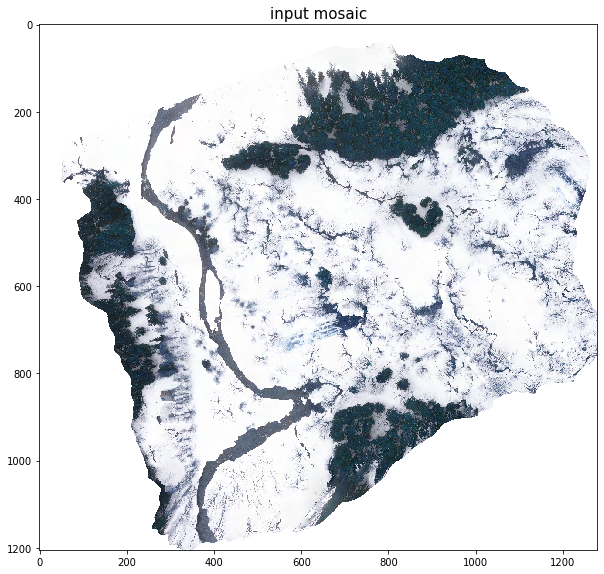

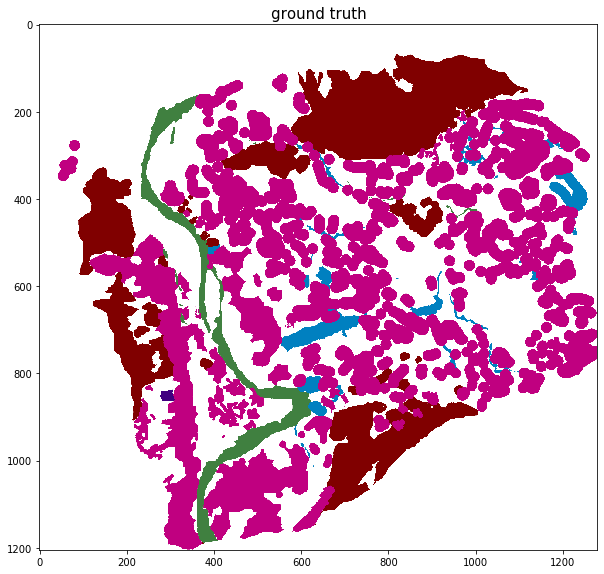

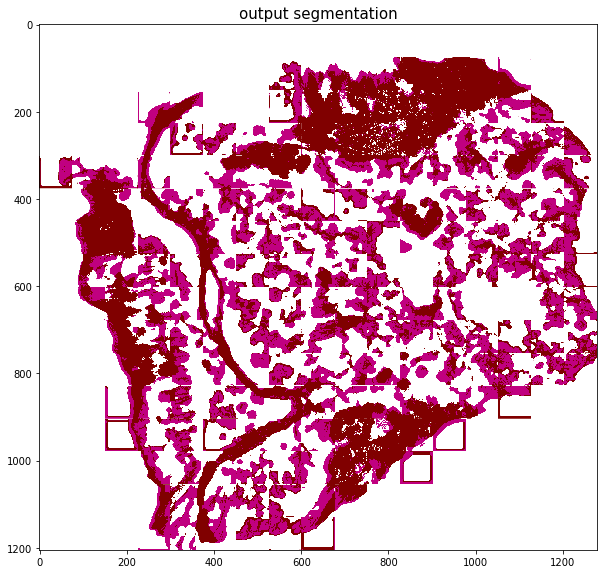

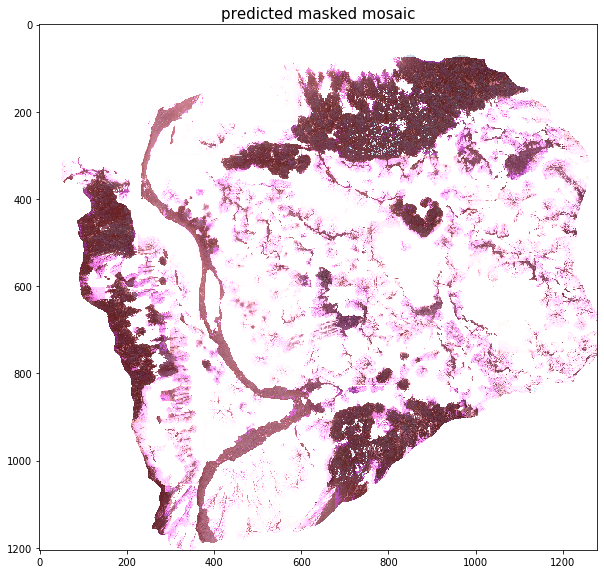

In [25]:
mosaic_segmentation("wM1", net)